# Quick Start PyTorch

Welcome to FloydHub! If you are here, you have just achieved your first success on FH: running your first Job, congrats! Now let's go through the 'Hello World' of DL: the handwrittend digit classification tast using PyTorch as Deep Learning Framework.

## One point, all the dependencies

Let's start defining what packgages we need to run this tutorial.

- [Numpy](http://www.numpy.org/) is the fundamental package for scientific computing with Python
- [PyTorch](http://pytorch.org/) is the Deep Learning framework we use
- [torchvision](http://pytorch.org/docs/master/torchvision/index.html) package consists of popular datasets, model architectures, and common image transformations for computer vision.
- [matplotlib](https://matplotlib.org/) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

# CUDA?
cuda = torch.cuda.is_available()

# Seed for replicability
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

## MNIST Dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is available for free and provide a good starting point into DL. `torchvision` already provides the MNIST API so we have not to define a custom pytorch dataset.

PyTorch experiments are structured in this way:

- create a PyTorch dataset if not already provided by the framework
- create an iterator on the dataset using the DataLoader API which combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

We have specified the `/MNIST` folder as absolute path, otherwise if we have used the local directory, the output of the instance will have contained also the data, consuming additional space and mixing code with data.

In [2]:
# Hyperparameters
batch_size = 8
num_workers = 1

# Download the MNIST dataset into the /MNIST folder if not mounted via FH --data
train = MNIST('/MNIST', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('/MNIST', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

if cuda:
    # Create DataLoader for cuda
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
else:
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False)
    
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

Processing...
Done!


### FloydHub best practice: separe the code from data

The MNIST dataset is not particulary big, but a good FloydHub practice is to have a clean separation from the code to the data. In this example we have a small dataset and the downloading and preprocessing steps do not require a lot of time, but in the case of bigger dataset, we would have waste a lot of time! Luckily FloydHub comes in help: you can upload your dataset on FloydHub and mount it on your Job. This practice decouple your experiments from your data, optimizing the experiments's iteration workflow.

For more info see: [create & upload a dataset](https://docs.floydhub.com/guides/create_and_upload_dataset/) and [mounting data to a job](https://docs.floydhub.com/guides/data/mounting_data/).

Let's take a closer look at MNIST:

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: 0.0
 - max: 1.0
 - mean: 0.13066047740240005
 - std: 0.3081078089011192
 - var: 0.0949304219058486


In [4]:
test_data = test.test_data
test_data = test.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.test_data.cpu().numpy().shape)
print(' - Tensor Shape:', test.test_data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: 0.0
 - max: 1.0
 - mean: 0.13251460696903547
 - std: 0.3104802693602732
 - var: 0.09639799766202778


So we have 60k black & white images of 28x28 pixels for training, and 10k for testing. Let's visualize what this sample look like:

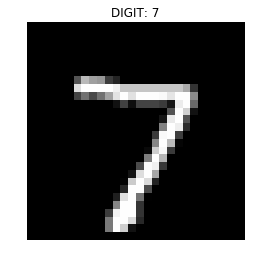

In [5]:
# Show a sample
plt.imshow(test.test_data.cpu()[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % test.test_labels.cpu()[0])
plt.axis('off')
plt.show()

In [6]:
# This is what it looks like seen as raw numbers in range 0-254,
# where 0 represent black pixels and 254 white pixels.

print (test.test_data.cpu()[0].numpy())

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 19

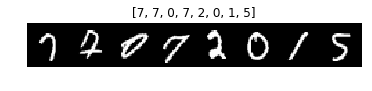

In [7]:
# More Visualization on grid format

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
trainset_iter = iter(train_loader)
images, labels = trainset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

Is time to prepare the DataLoader to perform the training, we have increased the batch size reducing the noise.

In [8]:
# Hyperparameters
batch_size = 64

if cuda:
    # Create DataLoader for cuda
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
else:
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False)
    
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

## Model

We use a 2 layer Neural Networks with ReLU as activation function, BatchNormalization and Dropout as regularizer.

In [9]:
# Hyperparameters
input_size = 784 # 28 * 28
hidden_size = 548
hidden_size2 = 252
num_classes = 10
learning_rate = 1e-3

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bc1 = nn.BatchNorm1d(hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.bc2 = nn.BatchNorm1d(hidden_size2)
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        out = F.log_softmax(h)
        return out

model = Model()

if cuda:
    model.cuda() # CUDA!

# Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()    

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train

Perform a 15 epochs training and plot Loss and Accuracy over the epochs.

In [10]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 0.4084, Accuracy: 89.0625
Epoch: [1/5], Step: [200/937], Loss: 0.3083, Accuracy: 89.0625
Epoch: [1/5], Step: [300/937], Loss: 0.2915, Accuracy: 92.1875
Epoch: [1/5], Step: [400/937], Loss: 0.1932, Accuracy: 90.6250
Epoch: [1/5], Step: [500/937], Loss: 0.2441, Accuracy: 95.3125
Epoch: [1/5], Step: [600/937], Loss: 0.2998, Accuracy: 90.6250
Epoch: [1/5], Step: [700/937], Loss: 0.2585, Accuracy: 93.7500
Epoch: [1/5], Step: [800/937], Loss: 0.1705, Accuracy: 92.1875
Epoch: [1/5], Step: [900/937], Loss: 0.0739, Accuracy: 96.8750
Epoch: [2/5], Step: [100/937], Loss: 0.4075, Accuracy: 85.9375
Epoch: [2/5], Step: [200/937], Loss: 0.1415, Accuracy: 95.3125
Epoch: [2/5], Step: [300/937], Loss: 0.0647, Accuracy: 96.8750
Epoch: [2/5], Step: [400/937], Loss: 0.1792, Accuracy: 93.7500
Epoch: [2/5], Step: [500/937], Loss: 0.0555, Accuracy: 98.4375
Epoch: [2/5], Step: [600/937], Loss: 0.1164, Accuracy: 95.3125
Epoch: [2/5], Step: [700/937], Loss: 0.1178, Accuracy: 

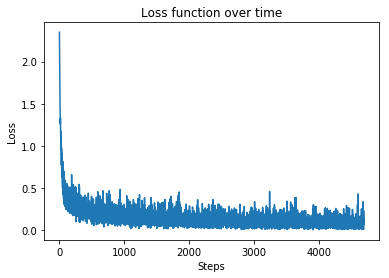

In [11]:
# Plot Loss over time
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

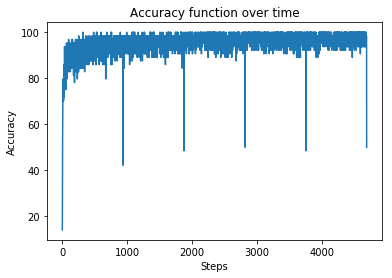

In [12]:
# Plot Accuracy over time
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

## Evaluate

Evaluate the trained model over the full test set.

In [13]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data.view(-1, 28*28), volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 98.12%


## Summary

Great you have achieved 98% of accuracy and familiarize with Jupyter Notebook running a Deep Learning workflow on FloydHub. This is only the starting point on your Deep Learning journey on FH, we encourage you to experiments.

If you need help on DeepLearning content or you cannot find an answer to your questions after read our great [Docs](https://docs.floydhub.com/), you can open a Topic in the [Forum](https://forum.floydhub.com/) where we provide a great customer service there :). Moreover your issues can help us to improving FloydHub and other users and solving your same problems.

Happy Learning!